In [1]:
import sys

sys.path.append('../../../MembraneQuant')
from membranequant import *
import seaborn as sns
import scipy.odr as odr
from scipy.optimize import curve_fit
import sympy as sp
import scipy.stats as st

%matplotlib notebook

### Data

In [2]:
df = pd.read_csv('../res1_df.csv')

In [4]:
x_wt = df[df.Line == 'nwg201'].Cyt.to_numpy()
y_wt = df[df.Line == 'nwg201'].Mem_tot.to_numpy()

x_l109r = df[df.Line == 'nwg369'].Cyt.to_numpy()
y_l109r = df[df.Line == 'nwg369'].Mem_tot.to_numpy()

In [5]:
a = 0.01 # thickness of cortical compartment in um
b = 1e-8  # molar concentration of wild type cytoplasm
c = 2.8893596260583494  # conversion factor for membrane concentrations

xc = b
xm = c * (y_wt_full / x_wt_full) * (1 / a) * b

In [6]:
cyts1 = np.r_[x_wt, x_l109r * 0]
cyts2 = np.r_[x_wt * 0, x_l109r]
cyts = np.c_[cyts1, cyts2]
mems = np.r_[y_wt, y_l109r]

### Functions

In [7]:
def fitting(model, cyts, mems):
    # Ols fit
    popt, pcov = curve_fit(model, cyts.T, mems)
    params_0 = popt

    # Odr fit
    def perform_odr(x, y):
        quadr = odr.Model(lambda B, x: model(x, *B))
        mydata = odr.Data(x, y)
        myodr = odr.ODR(mydata, quadr, beta0=params_0)
        output = myodr.run()
        return output

    regression = perform_odr(cyts.T, mems)
    params = regression.beta
            
    return params

# def bootstrap_fitting(model, cyts, mems, n):
#     params = []
#     for i in range(n):  
#         inds = np.random.choice(range(len(cyts)), len(cyts))
#         try:
#             params.append(fitting(model, cyts[inds], mems[inds]))
#         except:
#             pass
#     return params

def bootstrap_fitting(model, c1, c2, m1, m2, n):
    params = []
    for i in range(n):  
        inds1 = np.random.choice(range(len(c1)), len(c1))
        inds2 = np.random.choice(range(len(c2)), len(c2))
        _c1 = c1[inds1]
        _c2 = c2[inds2]
        
        cyts1 = np.r_[_c1, _c2 * 0]
        cyts2 = np.r_[_c1 * 0, _c2]
        cyts = np.c_[cyts1, cyts2]
        mems = np.r_[m1[inds1], m2[inds2]]
                    
        try:
            params.append(fitting(model, cyts, mems))
        except:
            pass
        
    return params

def confidence_interval(model, cyts, mems, params, interval=95, n_x=100): 
    x1 = np.linspace(0, np.max(cyts[:, 0]), n_x)
    x2 = np.linspace(0, np.max(cyts[:, 1]), n_x)
    all_fits = np.zeros([n_x, len(params)])
    for i, (_x1, _x2) in enumerate(zip(x1, x2)):
        for j, p in enumerate(params):
            all_fits[i, j] = model([_x1, _x2], *p)
    
    all_fits_lower = np.percentile(all_fits, (100 - interval) / 2, axis=1)
    all_fits_upper = np.percentile(all_fits, 50 + (interval / 2), axis=1)
    return [x1, x2, all_fits_lower, all_fits_upper]

In [8]:
def model(cyt, ka1, ka2, km):
    c1 = cyt[0] * xc
    m1 = c1 * km * (c1 * ka1 * km * (2 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1) + np.sqrt(
        4 * c1 ** 3 * ka1 ** 3 + 6 * c1 ** 2 * ka1 ** 2 * np.sqrt(
            4 * c1 * ka1 + 1) + 18 * c1 ** 2 * ka1 ** 2 + 8 * c1 * ka1 * np.sqrt(
            4 * c1 * ka1 + 1) + 12 * c1 * ka1 + 2 * np.sqrt(4 * c1 * ka1 + 1) + 2)) / (
                2 * c1 ** 2 * ka1 ** 2 + 2 * c1 * ka1 * np.sqrt(4 * c1 * ka1 + 1) + 4 * c1 * ka1 + np.sqrt(4 * c1 * ka1 + 1) + 1)
    
    c2 = cyt[1] * xc
    m2 = c2 * km * (c2 * ka2 * km * (2 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1) + np.sqrt(
        4 * c2 ** 3 * ka2 ** 3 + 6 * c2 ** 2 * ka2 ** 2 * np.sqrt(
            4 * c2 * ka2 + 1) + 18 * c2 ** 2 * ka2 ** 2 + 8 * c2 * ka2 * np.sqrt(
            4 * c2 * ka2 + 1) + 12 * c2 * ka2 + 2 * np.sqrt(4 * c2 * ka2 + 1) + 2)) / (
                2 * c2 ** 2 * ka2 ** 2 + 2 * c2 * ka2 * np.sqrt(4 * c2 * ka2 + 1) + 4 * c2 * ka2 + np.sqrt(4 * c2 * ka2 + 1) + 1)
    
    
    return m1 / xm + m2 / xm

### Fitting

In [9]:
p = fitting(model, cyts, mems)
print(np.log(p))

[12.98532161 11.15866183  5.93789831]


In [10]:
# fig, ax = plt.subplots()

# x = np.c_[np.linspace(0, max(x_wt), 100), np.zeros(100)]
# ax.plot(x[:, 0], model(x.T, *p))
# ax.scatter(x_wt, y_wt)

# x = np.c_[np.zeros(100), np.linspace(0, max(x_l109r), 100)]
# ax.plot(x[:, 1], model(x.T, *p))
# ax.scatter(x_l109r, y_l109r)

### Bootstrapping

In [11]:
pb = bootstrap_fitting(model, x_wt, x_l109r, y_wt, y_l109r, n=1000)
p_bootstrap = np.log(np.array(pb))

<IPython.core.display.Javascript object>


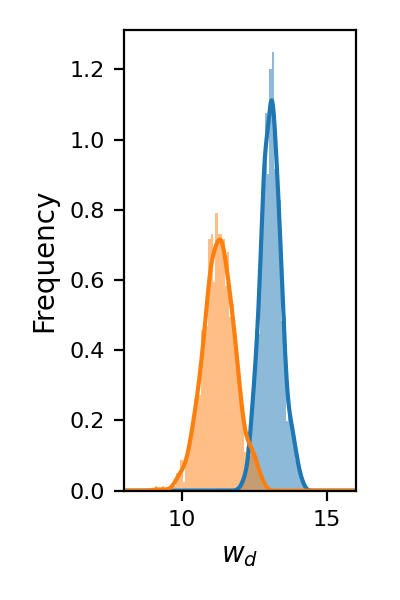

In [12]:
fig, ax = plt.subplots()

kde = st.gaussian_kde(p_bootstrap[:, 0])
xx = np.linspace(8, 16, 1000)
ax.plot(xx, kde(xx), c='tab:blue')

kde = st.gaussian_kde(p_bootstrap[:, 1])
xx = np.linspace(8, 16, 1000)
ax.plot(xx, kde(xx), c='tab:orange')

ax.hist(p_bootstrap[:, 0], bins=np.linspace(8, 16, 100), alpha=0.5, density=True)
ax.hist(p_bootstrap[:, 1], bins=np.linspace(8, 16, 100), alpha=0.5, density=True);
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel(r'$w_d$')
ax.set_ylabel('Frequency')
ax.set_xlim(8, 16)
fig.set_size_inches(2, 3)
fig.tight_layout()
# fig.savefig('Figs/wt_vs_l109r_wd.png', dpi=600, transparent=True)

<IPython.core.display.Javascript object>


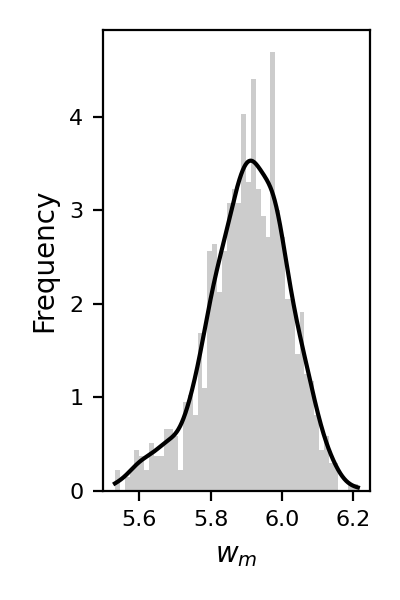

In [13]:
fig, ax = plt.subplots()

kde = st.gaussian_kde(p_bootstrap[:, 2])
xx = np.linspace(np.min(p_bootstrap[:, 2]), np.max(p_bootstrap[:, 2]), 1000)
ax.plot(xx, kde(xx), c='k')

ax.hist(p_bootstrap[:, 2], bins=50, alpha=0.2, color='k', density=True)
ax.tick_params(axis='both', labelsize=8)
ax.set_xlabel(r'$w_m$')
ax.set_ylabel('Frequency')
fig.set_size_inches(2, 3)
fig.tight_layout()
# fig.savefig('Figs/wt_vs_l109r_wm.png', dpi=600, transparent=True)

### 2D plot

<IPython.core.display.Javascript object>


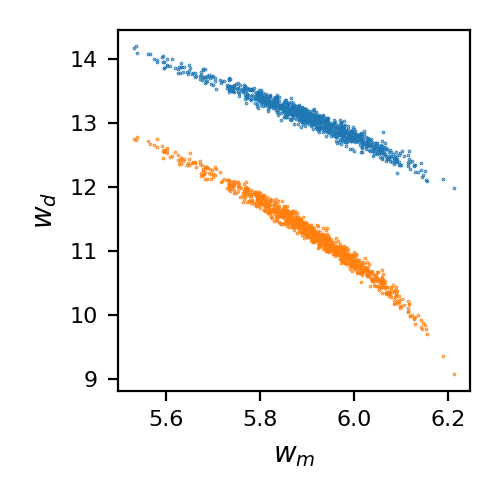

In [14]:
fig, ax = plt.subplots()
ax.scatter(p_bootstrap[:, 2], p_bootstrap[:, 0], c='tab:blue', s=0.1)
ax.scatter(p_bootstrap[:, 2], p_bootstrap[:, 1], c='tab:orange', s=0.1)
    
ax.set_xlabel(r'$w_m$')
ax.set_ylabel(r'$w_d$')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(2.5, 2.5)
fig.tight_layout()

### Confidence interval

In [15]:
ci_wt = confidence_interval(model, np.c_[x_wt, np.zeros(len(x_wt))], y_wt, pb, interval=95, n_x=100)
ci_l109r = confidence_interval(model, np.c_[np.zeros(len(x_l109r)), x_l109r], y_l109r, pb, interval=95, n_x=100)

<IPython.core.display.Javascript object>


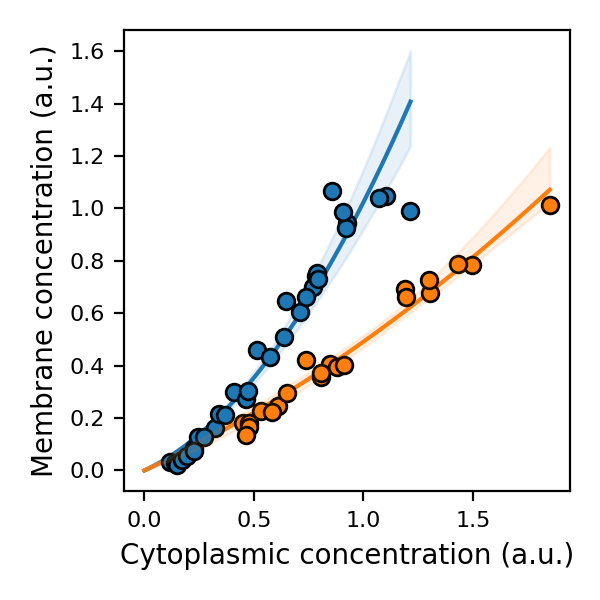

In [16]:
fig, ax = plt.subplots()

x = np.c_[np.linspace(0, max(x_wt), 100), np.zeros(100)]
ax.plot(x[:, 0], model(x.T, *p), c='tab:blue', zorder=0)
ax.scatter(x_wt, y_wt, c='tab:blue', edgecolors='k')
ax.fill_between(ci_wt[0], ci_wt[2], ci_wt[3], alpha=0.1, color='tab:blue')

x = np.c_[np.zeros(100), np.linspace(0, max(x_l109r), 100)]
ax.plot(x[:, 1], model(x.T, *p), c='tab:orange', zorder=0)
ax.scatter(x_l109r, y_l109r, c='tab:orange', edgecolors='k')
ax.fill_between(ci_l109r[1], ci_l109r[2], ci_l109r[3], alpha=0.1, color='tab:orange')

ax.set_xlabel('Cytoplasmic concentration (a.u.)')
ax.set_ylabel('Membrane concentration (a.u.)')
ax.tick_params(axis='both', labelsize=8)
fig.set_size_inches(3, 3)
fig.tight_layout()
# fig.savefig('Figs/wt_vs_l109r_ci.png', dpi=600, transparent=True)

### Dimeric state

In [ ]:
def monomer_fraction(conc, wd):
    return ((np.sqrt(4*conc*np.exp(wd) + 1) - 1)*np.exp(-wd)/2) / conc